# Tugas Kecil 1 **Machine Learning**
_Made by_:
- Ubaidillah Ariq Prathama - 13520085
-  Patrick Amadeus Irawan - 1350109

----

## Table of Contents

* [Library & Dependencies](#library)
* [Load & Split Dataset](#load)
    * [Structure & Datatype Analysis](#structure)
    * [Splitting Dataset](#splitting)
* [Base Model & Training Export](#base)
    * [Creating Base Model](#create)
    * [Base Model Fitting & Exporting](#fitting)
* [Base Model Evaluation](#evaluation)
    * [F1-Score Comparison](#comparison)
* [KMeans Analysis & Refactor](#kmeans)
    * [Base Model Analysis](#kmeansbase)
    * [Finding Optimal n_clusters](#n-clusters)
    * [Refactor KMeans Model](#refactor)
    * [Re-evaluate KMeans Models Score](#reevaluate)
* [Classification Model Analysis](#classification)
    * [Predicting Test Data](#predicting)
    * [Evaluation Metrics Summary](#evaluation-metrics)
    * [Metrics Visualization & Analysis](#metrics-visualization)
    * [Analisa Untuk Tiap Metric](#analisa)
    * [Confusion Matrix](#confusion-matrix)
* [Decision Tree Classifier Visualization & K-Fold Cross Validation](#k-fold)
    * [K-Fold Implementation](#k-fold-implementation)
* [Experimentation on Improving Best Base Model](#experiment)


## **Library** & **Dependencies** <a id="library"></a>

In [57]:
# Base Util Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
SEED = 42

# Export, Import and Save Model Libraries
import six
import sys
sys.modules['sklearn.externals.six'] = six
import pickle

# Model Libraries
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier
from id3 import Id3Estimator
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

MODEL_DIR = './models/'

## **Load** & **Split** Dataset <a class="anchor" id="load"></a>

In [58]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Loading Dataset
dataset = load_breast_cancer()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target

### Structure & Data Type Analysis <a class="anchor" id="structure"></a>

In [59]:
display(pd.DataFrame({"Dataset Shape": df.shape}, index = ["Row", "Column"]).T \
                    .style.set_caption("DATA SHAPE"))
dtype_dict = {}
dtype_sample_dict = {}

# get amount of every datatype
for col in df.columns:
    dtype_dict[df[col].dtype] = dtype_dict.get(df[col].dtype, 0) + 1
    dtype_sample_dict[col] = [df[col].dtype, df[col].
                              sample(1, random_state = SEED).values[0]]

# Numerical Summary
display(pd.DataFrame(dtype_dict, index = ["Column Count"]).T \
                    .style.set_caption("COLUMN DTYPE SUMMARY"))

# Sanity Check with sampling
display(pd.DataFrame(dtype_sample_dict, index = ["dtype", "data_sample"]).T \
                .style.set_caption("SANITY CHECK (w/ Random Sampling)"))


,Row,Column
Dataset Shape,569,31


,Column Count
float64,30
int32,1


,dtype,data_sample
mean radius,float64,12.470000
mean texture,float64,18.600000
mean perimeter,float64,81.090000
mean area,float64,481.900000
mean smoothness,float64,0.099650
mean compactness,float64,0.105800
mean concavity,float64,0.080050
mean concave points,float64,0.038210
mean symmetry,float64,0.192500
mean fractal dimension,float64,0.063730


Analisis tipe data kolom menunjukkan bahwa keseluruhan atribut memiliki tipe data numerik, kecuali kolom `target` yang merupakan atribut kategorikal (nominal). Dengan demikian, tidak diperlukan ada nya _encoding_ untuk atribut yang digunakan sebagai fitur pelatihan model.

In [60]:
df.target.value_counts()

1    357
0    212
Name: target, dtype: int64

### Splitting Dataset <a class="anchor" id="splitting"></a>

In [61]:
# Splitting Dataset
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, 
                                                    random_state=SEED)

# Sanity Verbose
shape_dict = {
    "dataset": df.shape,
    "x_train": X_train.shape,
    "y_train": [y_train.shape[0],1],
    "x_test": X_test.shape,
    "y_test": [y_test.shape[0],1]
}
display(pd.DataFrame(shape_dict, index = ["row", "column"]).
        style.set_caption("SUMMARY OF DATA SHAPES"))


,dataset,x_train,y_train,x_test,y_test
row,569,455,455,114,114
column,31,30,1,30,1


## Base Model **Training** & **Export** <a class="anchor" id="base"></a>

### Creating Base Model <a class="anchor" id="create"></a>

In [62]:
# Decision Tree Based
dtc = DecisionTreeClassifier(random_state=SEED)
id3 = Id3Estimator()
# Clustering
kmn = KMeans(random_state=13)
# Logistic Regression
logreg = LogisticRegression(random_state=SEED)
# Perceptron
mlpc = MLPClassifier(random_state=SEED)
# Support Vector
svc = SVC(random_state=SEED)

models = { "dtc" : dtc, "id3" : id3, "kmn" : kmn,
            "logreg" : logreg, "mlpc" : mlpc, "svc" : svc }

### Base Model **Fitting** & **Exporting** <a class="anchor" id="fitting"></a>

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    pickle.dump(model, open(f'{MODEL_DIR}{name}.pkl', 'wb'))

## Base Model **Evaluation** <a class="anchor" id="evaluation"></a>

In [ ]:
f1_models = {}
pred_models = {}
for name, model in models.items():
    y_pred = pickle.load(open(f'{MODEL_DIR}{name}.pkl', 'rb')).predict(X_test)
    pred_models[name] = y_pred
    f1_models[name] = classification_report(
        y_test, y_pred, output_dict=True)['weighted avg']['f1-score']

### F1-Score Comparison <a class="anchor" id="comparison"></a>

In [65]:
def f1_plot(f1_models, cfg = None):
    plt.figure(figsize=(10,5))
    
    color = 'grey'
    if cfg != None:
        color = None

    sns.barplot(x=list(f1_models.values()), y=list(f1_models.keys()), 
                orient='h', palette=cfg, color=color)

    for i, v in enumerate(f1_models.values()):
        plt.text(v, i, " "+str(round(v, 2)), color='black', 
                 va='center', fontweight='bold')


    # Title & Styling
    plt.xticks([0,1])
    plt.gca().set_facecolor('white')
    plt.title(r"$\bf{" + "F1-Score" + "}$ of Base Models", 
              fontsize=20, pad = 20)
    plt.show()

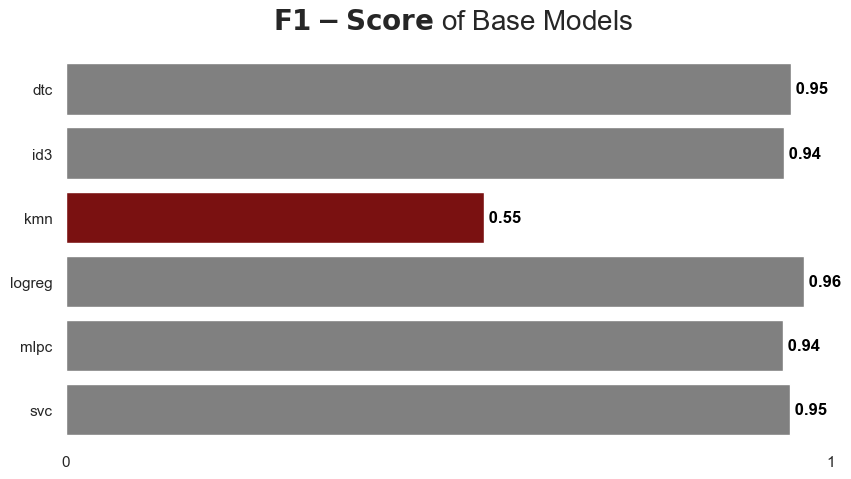

In [66]:
bad_cfg = ['grey' if (x > min(f1_models.values())) 
           else 'darkred' for x in f1_models.values()]
f1_plot(f1_models, bad_cfg)

Secara garis besar, model _non-clustering_ memiliki nilai F1-Score yang cukup tinggi pada evaluasi dengan data testing dengan nilai akurasi tertinggi berasal dari model **Logistic Regression**.

Apabila ditinjau dari perbandingan F1-Score yang dimiliki setiap model, terdapat kejanggalan pada model **KMeans** dengan akurasi yang jauh lebih rendah. Oleh karena itu, perlu dilakukan analisis lebih lanjut spesifik terhadap _base model_ tersebut.

## **KMeans** Analysis & Refactor <a class="anchor" id="kmeans"></a>

### **Base Model Analysis** <a class="anchor" id="kmeansbase"></a>

Dilansir dari [dokumentasi](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), jumlah centroid yang didefinisikan pada _base_model_ adalah sejumlah **8**.

> n_clusters : **_int_, default=8** \
    The number of clusters to form as well as the number of centroids to generate.

 Pada kasus ini, jumlah centroid tersebut secara intuisi tidak sesuai representasi jumlah target pada dataset. Oleh karena itu, perlu dilakukan _refactor_ pada model **KMeans** dengan mengubah `n_clusters` yang memiliki galat WCSS terendah.

### **Finding Optimal `n_clusters`** <a class="anchor" id="n-clusters"></a>

Within-Cluster Sum of Square (WCSS) adalah metric untuk mengukur jarak antara tiap instans data pada centroid yang terbentuk. Dengan demikian, semakin kecil nilai WCSS, maka semakin baik model yang dibentuk.



Salah satu metode pencarian nilai `n_clusters` yang optimal adalah dengan menggunakan metode _elbow_method_ yang mana nilai `n_clusters` yang optimal adalah nilai `n_clusters` yang memiliki nilai WCSS terendah sebelum perubahan WCSS cenderung melandai, yakni mencari _elbow_ pada grafik WCSS.

In [ ]:
df_kmn = df.drop('target', axis=1)

clusters = []
for i in range(1,11):
    kmn_ = KMeans(n_clusters = i, random_state=SEED).fit(df_kmn)
    clusters.append(kmn_.inertia_)

f,ax = plt.subplots(figsize = (10,6))
plt.plot([i for i in range(1,11)] , clusters , 
         markevery = [1], marker = "o" , markersize = 7)
plt.title("KMeans Elbow Method" ,size= 20)
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks([i for i in range(1,11)])
plt.show()

Pemilihan `n_clusters` yang optimal pada kasus ini adalah **2**, konsisten dengan jumlah target yang ada pada dataset dengan label diketahui. Alasan pemilihan hanya berhenti di 2, bukan pada WCSS yang lebih rendah dikarenakan keberadaan _centroid_ yang lebih banyak tentunya akan cenderung menurunkan nilai WCSS secara total tetapi dengan rasio yang tidak signifikan. Penggunaan metode _elbow_ bertujuan untuk mencari `n_clusters` terakhir dimana terjadi penurunan WCSS yang signifikan.

### Refactor **KMeans** Model <a class="anchor" id="refactor"></a>

In [ ]:
ref_kmn = KMeans(n_clusters = 2, random_state=SEED).fit(X_train)
models['kmn'] = ref_kmn
pickle.dump(ref_kmn, open(f'{MODEL_DIR}kmn.pkl', 'wb'))

### Re-evaluate Models' Score <a class="anchor" id="reevaluate"></a>

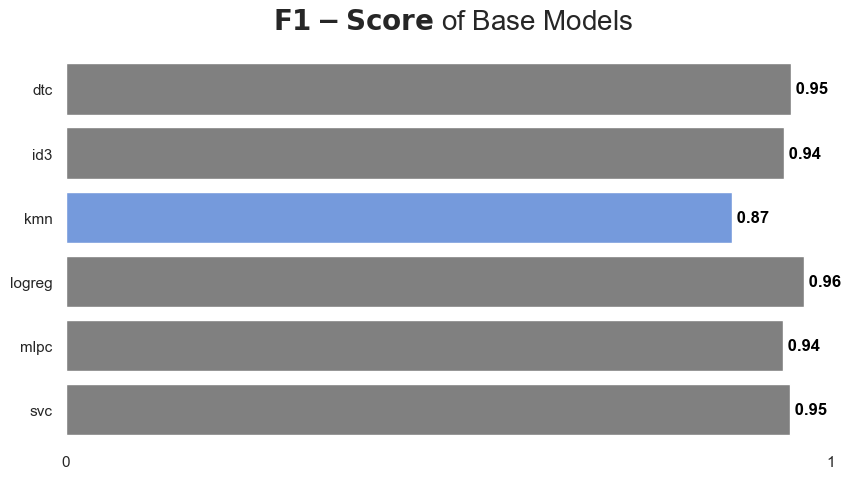

In [69]:
y_pred = pickle.load(open(f'{MODEL_DIR}kmn.pkl', 'rb')).predict(X_test)

f1_ = classification_report(y_test, y_pred, 
                            output_dict=True)['weighted avg']['f1-score']
if f1_ < 0.3:
    y_pred = [1 if x == 0 else 0 for x in y_pred]

pred_models['kmn'] = y_pred
f1_models['kmn'] = classification_report(y_test, y_pred, 
                                         output_dict=True)['weighted avg']['f1-score']

eval_cfg = ['grey' if (x > min(f1_models.values())) 
            else 'cornflowerblue' for x in f1_models.values()]
f1_plot(f1_models,eval_cfg)

Dengan menggunakan pemilihan `n_clusters` yang tepat, nilai F1-Score pada model **KMeans** meningkat menjadi 0.87, drastis apabila dibandingkan dengan performa **KMeans** pada _base model_.

Perlu dicatat bahwa pada `SEED` yang diatur diperlukan adanya _mapping_ nilai target yang dihasilkan oleh model **KMeans** dengan nilai target yang ada pada dataset. Hal ini dikarenakan model **KMeans** hanya mengelompokkan data sesuai dengan kemiripannya **TANPA** secara otomatis tanpa mempedulikan konsistensi dengan label target sesungguhnya, yakni 0 dan 1.

Representasi mapping ada pada segmen kode
```py
f1_ = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']

# Flip Label target if f1-score is below 0.3, assume that it caused by mislabeling
if f1_ < 0.3:
    y_pred = [1 if x == 0 else 0 for x in y_pred]
```

## Classification Model **Analysis** <a class="anchor" id="classification"></a>

Analisis performa klasifikasi menggunakan **f1-score** dan **confusion matrix**. Kedua metrics berkaitan merupakan metrik yang umum digunakan untuk menganalisa performa klasifikasi.

### **Predicting** Test Data <a class="anchor" id="predicting"></a>

In [70]:
pred_models = {}
# Predict for every model
for name, model in models.items():
    y_pred = pickle.load(open(f'{MODEL_DIR}{name}.pkl', 'rb')).predict(X_test)

    if name == 'kmn':
        f1_ = classification_report(y_test, y_pred, 
                                    output_dict=True)['weighted avg']['f1-score']
        if f1_ < 0.3:
            y_pred = [1 if x == 0 else 0 for x in y_pred]

    pred_models[name] = y_pred

### Evaluation Metrics Summary <a class="anchor" id="evaluation-metrics"></a>

In [71]:
from sklearn.metrics import accuracy_score

f1_scores_test = {}
d_ctab = {}

targets = ['0', '1']
metrics = ['precision','recall', 'f1-score']

n_model = len(pred_models.keys())
idx = [[],[]]
data = []
for i in pred_models.keys():
    idx[0] += [i] * 2
    idx[1].append('0')
    idx[1].append('1')

for name, y_pred in pred_models.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    accu = accuracy_score(y_test, y_pred)

    for target in targets:
        sub_data = []
        for metric in metrics:
            sub_data.append(report[target][metric])
        sub_data.append(accu if target == '0' else '(same as above)')
        data.append(sub_data)

    f1_scores_test[name] = report['weighted avg']['f1-score']

df_eval = pd.DataFrame(data, index=idx, columns=metrics 
                       + ['accuracy']).rename_axis(['Model', 'Label'])
df_eval.style.set_caption("METRICS SUMMARY")


### Metrics **Visualization** & **Analysis** <a class="anchor" id="metrics-visualization"></a>

Setelah melakukan prediksi terhadap _testing_data_, akan dilakukan analisis terhadap 3 metrics utama, yakni:
1. **F1-Score** : merupakan nilai kalkulasi dari _precision_ dan _recall_ yang dihasilkan oleh model.
2. **Precision** : merupakan nilai yang mengukur seberapa akurat model dalam memprediksi data yang benar-benar positif dari keseluruhan tebakannya.
3. **Recall** : merupakan nilai yang mengukur seberapa akurat model dalam memprediksi data yang benar-benar positif dari keseluruhan data yang sebenarnya positif.

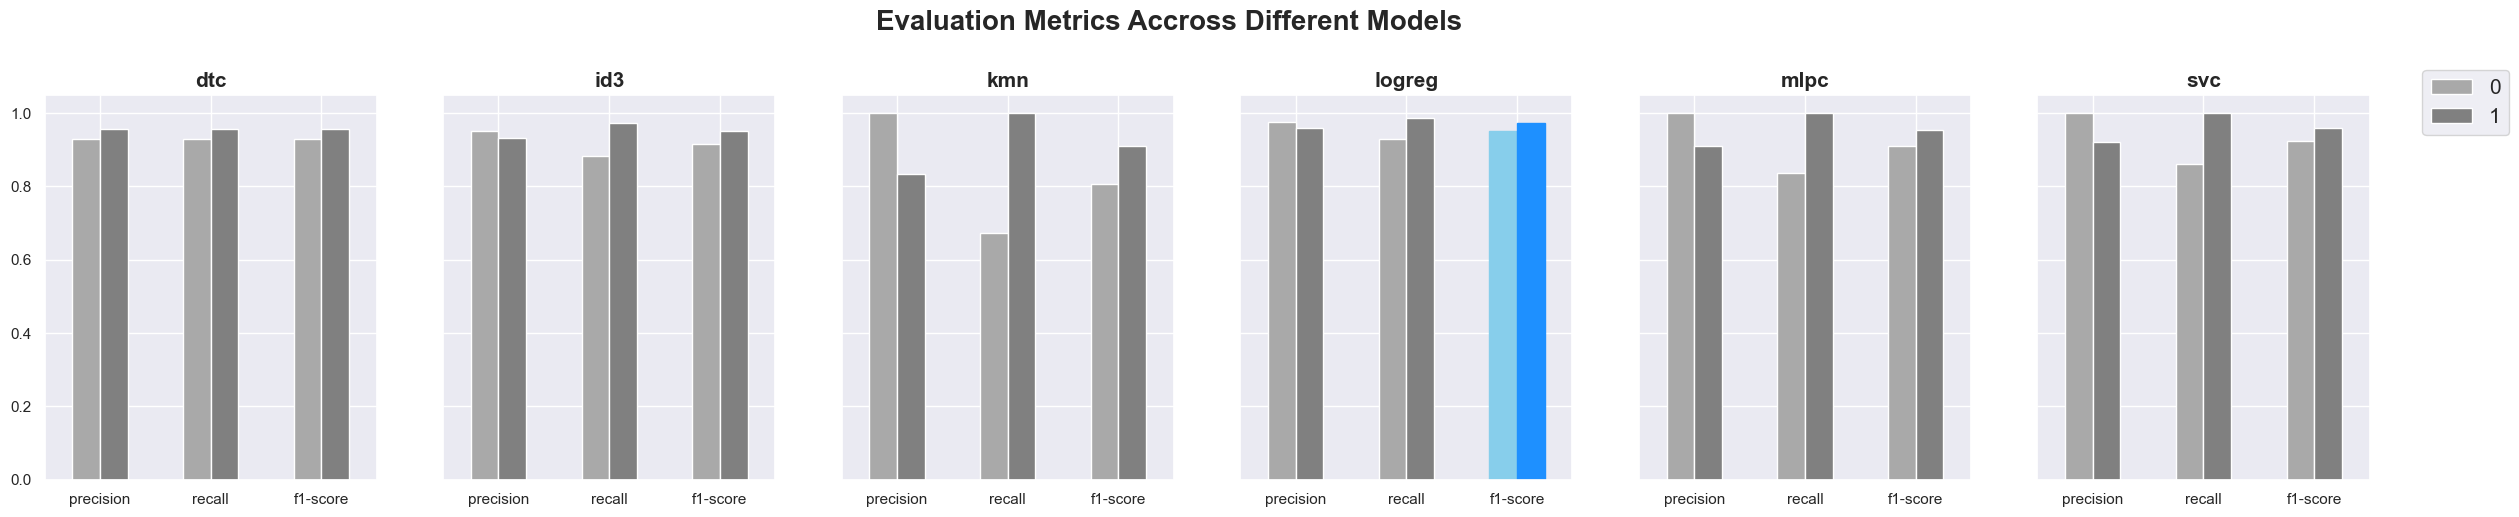

In [72]:
fig, ax = plt.subplots(1,6, sharey = True, figsize = (30,5))
best_model = df_eval[['f1-score']].idxmax(axis=0)

i = 0
for model in pred_models.keys():
    df_eval.loc[model][df_eval.columns[:3]].T.plot(kind = "bar",
                                ax=ax[i], color = ['darkgrey' , 'grey'])

    if model == best_model[0][0]:
        # change f1-score bar to other color
        ax[i].get_children()[2].set_color('skyblue')
        ax[i].get_children()[5].set_color('dodgerblue')

    ax[i].set_title(model, fontsize=15, fontweight='bold')

    # turn off legend and rotate xticks
    ax[i].legend().set_visible(False)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(0)
    i += 1

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', 
           bbox_to_anchor=(0.95, 0.95), fontsize=15)
fig.suptitle('Evaluation Metrics Accross Different Models',
              fontsize=20, fontweight='bold', y=1.05)

plt.show()

### Analisa untuk tiap **_metric_** <a class="anchor" id="analisa"></a>

Secara garis besar, dapat dilihat bahwa model **Logistic Regression** memiliki performa pengujian yang paling baik di antara model lainnya, walau dengan galat yang cenderung kecil. Kasus klasifikasi menggunakan data `breast_cance` ini merupakan kasus yang cukup sederhana, sehingga secara umum _base_model_ dapat digunakan untuk mendapatkan hasil yang cukup optimal.

Analisa setiap _metric_ adalah sebagai berikut : 
1. **F1-Score** 

    Keseluruhan **f1-score** didapat dari perhitungan precision dan recall. **F1-Score** terbaik dimiliki oleh model _logreg_ dan terburuk dimiliki _kmeans_. Implementasi menggunakan _kmeans_ disinyalir memang kurang sesuai untuk use case klasifikasi yang merupakan _supervised learning_ sehingga performa yang dihasilkan cenderung lebih rendah. Selain itu, dapat dilihat bahwa **f1-score** label `0` cenderung lebih rendah dibandingkan dengan label `1`. 

    Berikut merupakan jumlah data untuk tiap label pada `dataset` utama,
    ```
    label 1  :  357
    label 0  :  212
    ```

    Salah satu faktor yang dapat berperan adalah adanya perbedaan proporsi jumlah pada _training_data_ dari kedua label, sehingga menimbulkan kecenderungan bias pada model latih yang lebih _favorable_ pada kasus dengan label berdata lebih banyak.

2. **Precision**
    
    Precision dinotasikan dalam rumus berikut

    $$Precision = \frac{TP}{TP + FP}$$

    Dengan demikian, **precision** merupakan nilai yang mengukur seberapa akurat model dalam memprediksi data yang **benar-benar** merupakan bagian dari label tertentu. Dari hasil evaluasi, dapat dilihat **5 dari 6** model memiliki _precision_ yang lebih tinggi pada label `0` dibandingkan lebal `1` dengan galat maksimal sebesar `0.2`. Fenomena ini dapat disebabkan beberapa ha, di antaranya pemilihan model dan jumlah data. 
    
    Berkaitan dengan jumlah data, telah dielaborasi bahwa data dengan label `0` berjumlah lebih sedikit. Semakin sedikit pelatihan pada suatu label, maka kecenderungan model untuk melakukan prediksi label terkait menurun. Hal ini merupakan kasus umum yang terjadi pada _imbalanced dataset_. Dengan basis tersebut, kecenderungan model untuk menebak label `0` akan lebih rendah sehingga meminimalisir kejadian **FALSE POSITIVE (FP)**. Rendahnya nilai **FP** akan berimplikasi pada meningkatnya nilai **precision**.

    Di sisi lain, label `1` lebih sering ditebak dikarenakan data latih mengenal lebih banyak kasus-kasus yang menghasilkan prediksi label bersangkutan, berimplikasi pada meningkatnya kecenderungan terjadinya **FALSE POSITIVE (FP)** sehingga terjadi penurunan pada nilai **precision**.

3. **Recall**
    
    Tingginya **precision** tidak selalu berujung pada performa model yang baik. Kecenderungan model untuk tidak melakukan prediksi pada label tertentu akan berimplikasi pada tinggnya nilai **FALSE NEGATIVE (FN)** karena banyak instans data yang gagal diprediksi.

    Recall dinotasikan dalam rumus berikut

    $$Recall = \frac{TP}{TP + FN}$$

    Dengan demikian, **recall** merupakan nilai yang mengukur seberapa akurat model dalam memprediksi **keseluruhan** data yang menjadi bagian dari label tertentu. Dari hasil evaluasi **semua** model memiliki tingkat **recall** pada label `0` lebih rendah dibandingkan label `1`. Hal ini berhubungan dengan metrics sebelumnya, yakni **precision**, dimana jumlah data merupakan faktor yang bermain pada tingkat **recall**. Semakin sedikit data yang dimiliki, maka tingkat **recall** akan semakin rendah dikarenakan model akan cenderung tidak melakukan prediksi yang mengeluarkan label terkait, alhasil kemungkinan terjadinya **FALSE NEGATIVE (FN)** lebih tinggi karena banyak instans data yang gagal diprediksi.

    Begitu pula sebaliknya, apabila model lebih familiar dengan label tertentu, maka kecenderungan model untuk melakukan prediksi label berkaitan lebih tinggi. Memang terdapat kemungkinan bahwa **FALSE POSITIVE (FP)** akan terjadi, tetapi khusus untuk metric **recall** yang hanya mempertimbangkan jumlah **FALSE NEGATIVE (FN)**, instans data yang gagal tertebak akan lebih sedikit.


### **Confusion Matrix**, persebaran kuantitatif prediksi instans data <a class="anchor" id="confusion-matrix"></a>

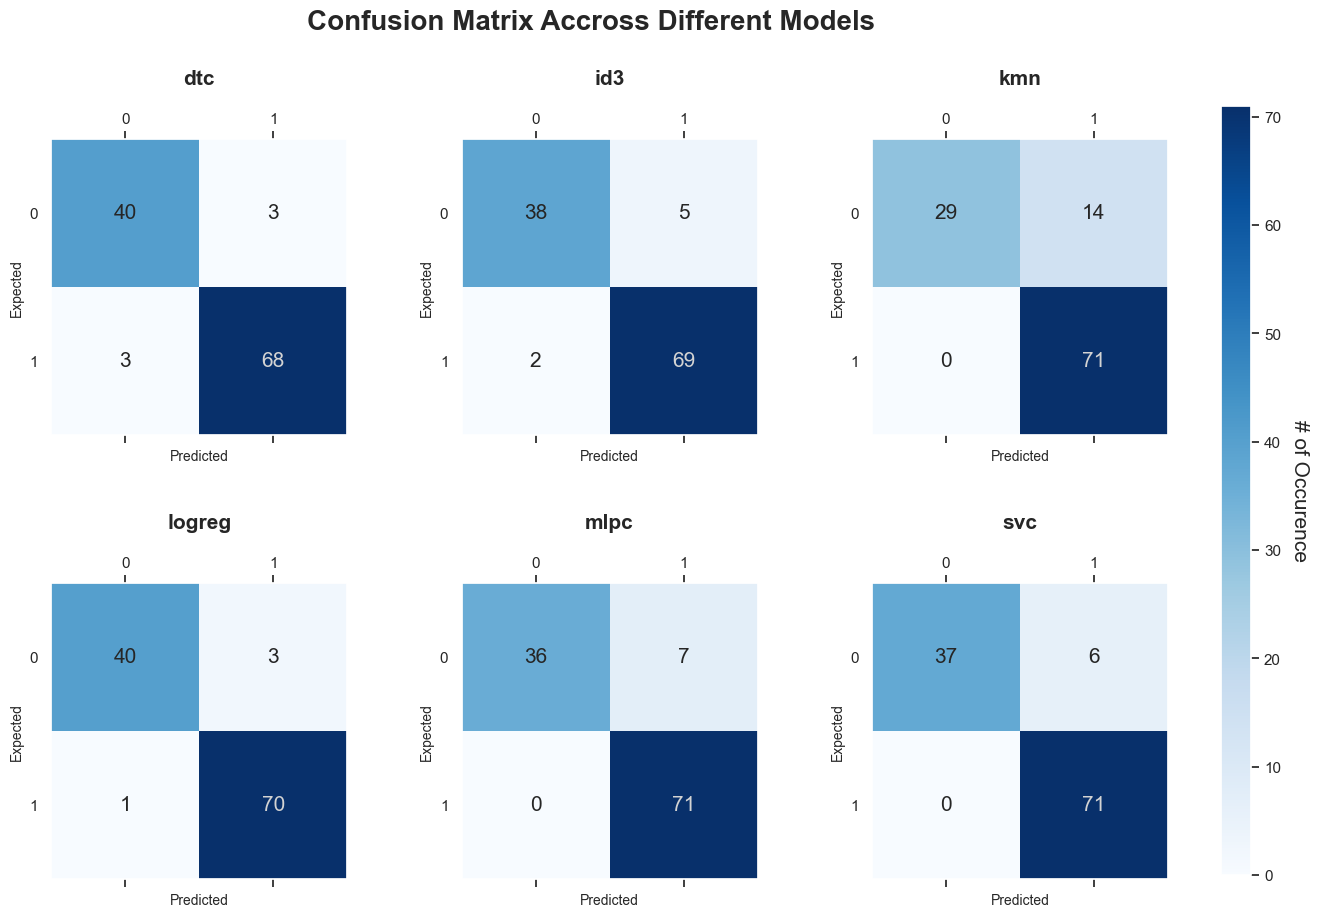

In [73]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

i = 0

for name, y_pred in pred_models.items():
    conf_mat = confusion_matrix(y_true=y_test, y_pred=pred_models[name])

    # show number inside matrix
    for (j,k),label in np.ndenumerate(conf_mat):
        if j == 1 and k == 1:
            ax[i // 3,i % 3].text(k,j,label,
                                  ha='center',va='center', color='lightgrey', fontsize=15)
        else:
            ax[i // 3,i % 3].text(k,j,label,
                                  ha='center',va='center', fontsize=15)

    # Mapping for every subplot
    ax[i // 3,i % 3].grid(False)
    ax[i // 3,i % 3].matshow(conf_mat, cmap=plt.cm.Blues)
    ax[i // 3,i % 3].set_title(name, pad=20, fontsize=15, fontweight='bold')
    ax[i // 3,i % 3].set_xlabel('Predicted', fontsize=10)
    ax[i // 3,i % 3].set_ylabel('Expected', fontsize=10)
    
    cax = ax[i // 3,i % 3].matshow(conf_mat, cmap=plt.cm.Blues)
    i += 1

box = ax[1,2].get_position()
colorBarPos = plt.axes([box.x0 + box.width + 0.02, box.y0, 0.02, box.height * 2.25])

fig.suptitle('Confusion Matrix Accross Different Models', 
             fontsize=20, fontweight='bold')
fig.subplots_adjust(top=0.85, hspace = 0.5)
cbar = plt.colorbar(cax, ax=ax, cax = colorBarPos)
cbar.ax.set_ylabel('# of Occurence',
                    rotation=270, fontsize=15, labelpad=20)
plt.show()

Selaras dengan analisis, **confusion matrix** memberikan validasi lebih lanjut bahwa terdapat lebih banyak kemunculan **FALSE POSITIVE (FP)** pada label `1`, yakni di setiap pojok kanan dari matriks tiap model.

Secara garis besar, dapat disimpulkan beberapa hal:
- **Logistic Regression** merupakan model yang paling optimal untuk kasus ini, dengan **f1-score** tertinggi, **precision** dan **recall** yang baik.
- Model yang memiliki **precision** tinggi dapat berarti dua hal:
    - Model bersangkutan baik performanya, atau
    - Model bersangkutan "takut" untuk melakukan prediksi pada label tertentu. Dapat diuji dengan membandingkan **recall**.
- Model yang memiliki **recall** tinggi dapat berarti dua hal:
    - Model bersangkutan baik performanya, atau
    - Model bersangkutan melakukan prediksi berlebihan pada labal tertentu. Dapat diuji dengan membandingkan **precision**.
- Umumnya, apabila konstruksi suatu model buruk, akan terjadi korelasi berbalik arah pada **precision** dan **recall** yang dimiliki. Apabila model buruk bersangkutan memiliki **precision** yang tinggi, maka **recall** akan rendah dan sebaliknya. _(dapat ditinjau pada bar chart, contohnya pada **kmn**)_

## **Decision Tree Classifier** Visualization & K-Fold Cross Validation <a class="anchor" id="k-fold"></a>

In [74]:
dtl = pickle.load(open(f'{MODEL_DIR}dtc.pkl', 'rb'))
print(export_text(dtl, feature_names=list(dataset.feature_names)))

|--- mean concave points <= 0.05
|   |--- worst radius <= 16.83
|   |   |--- area error <= 48.70
|   |   |   |--- worst smoothness <= 0.18
|   |   |   |   |--- smoothness error <= 0.00
|   |   |   |   |   |--- worst texture <= 27.76
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- worst texture >  27.76
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- smoothness error >  0.00
|   |   |   |   |   |--- worst texture <= 33.35
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- worst texture >  33.35
|   |   |   |   |   |   |--- worst texture <= 33.56
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- worst texture >  33.56
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- worst smoothness >  0.18
|   |   |   |   |--- class: 0
|   |   |--- area error >  48.70
|   |   |   |--- concavity error <= 0.02
|   |   |   |   |--- class: 0
|   |   |   |--- concavity error >  0.02
|   |   |   |   |--- class: 1
|   |--- worst radius >  16.

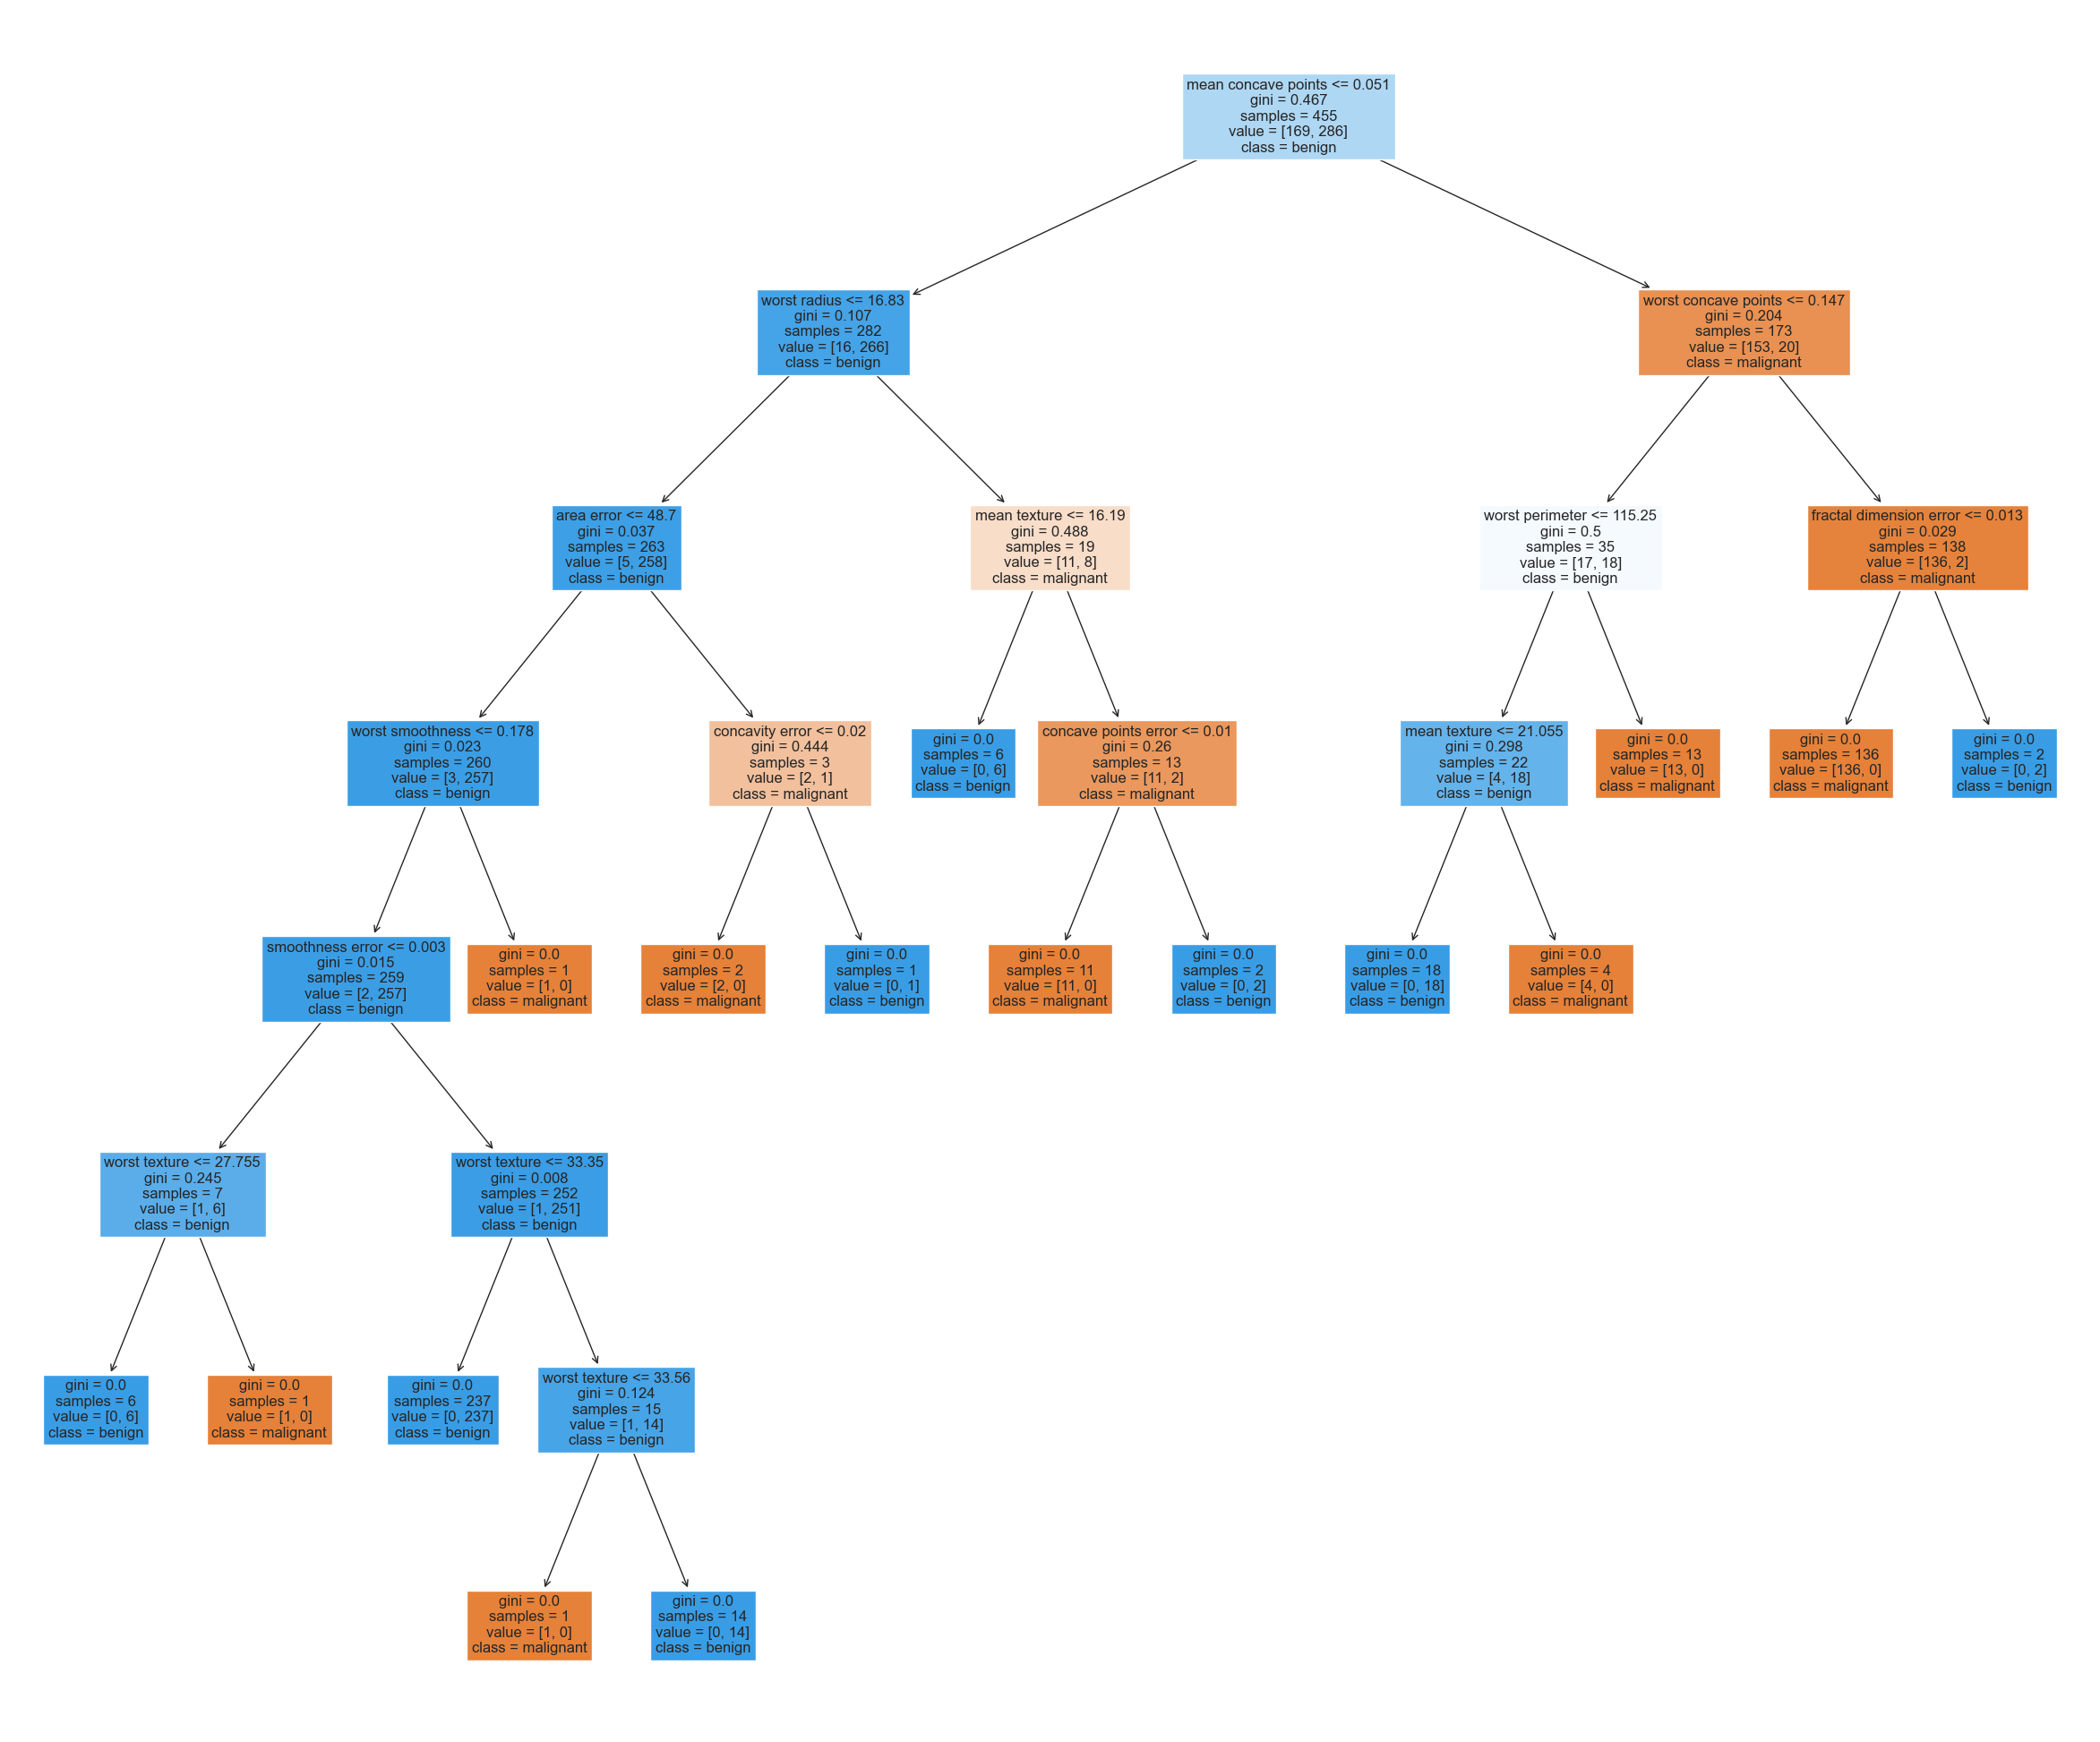

In [75]:
fig = plt.figure(figsize=(30,25))
_ = tree.plot_tree(dtl, 
                   feature_names=dataset.feature_names,  
                   class_names=dataset.target_names,
                   filled=True, fontsize=12)

Dengan menggunakan bantuan kakas visualisasi, dapat dilihat representasi model pohon keputusan yang telah dibuat pada representasi di atas.

### **KFold** Implementation <a class="anchor" id="k-fold-implementation"></a>

Base Accuracy Score:  0.9473684210526315
Mean K-Fold Accuracy Score:  0.9297584541062802


,f1,precision,recall,accuracy
type,,,,
base,0.947368,0.947368,0.947368,0.947368
k-fold,0.944021,0.945229,0.944335,0.929758


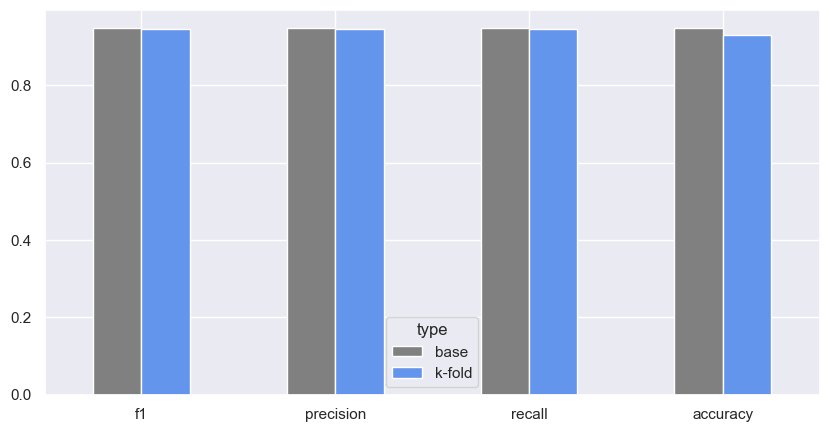

In [76]:
#10-fold cross validation for decision tree classifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

kfold = cross_validate(dtc, X_train, y_train, cv=10, 
                       scoring=['accuracy', 'f1', 'precision', 'recall'])

print("Base Accuracy Score: ", accuracy_score(y_test, pred_models['dtc']))
print("Mean K-Fold Accuracy Score: ", (kfold['test_accuracy'].mean()))


# Compare f1, precision, recall, accuracy between base model and k-fold model
d = []

d.append({
    'type' : 'base',
    'f1': f1_scores_test['dtc'],
    'precision': classification_report(y_test, pred_models['dtc'], 
                                       output_dict=True)['weighted avg']['precision'],
    'recall': classification_report(y_test, pred_models['dtc'], 
                                    output_dict=True)['weighted avg']['recall'],
    'accuracy': accuracy_score(y_test, pred_models['dtc'])
})

d.append({
    'type' : 'k-fold',
    'f1': kfold['test_f1'].mean(),
    'precision': kfold['test_precision'].mean(),
    'recall': kfold['test_recall'].mean(),
    'accuracy': kfold['test_accuracy'].mean()
})

df_kfold = pd.DataFrame(d).set_index('type')
display(df_kfold.style.set_caption("Comparison between base model and k-fold model"))

# Plot the comparison
df_kfold.T.plot(kind='bar', figsize=(10,5), 
                rot=0, color=['grey', 'cornflowerblue'])
plt.show()

KFold digunakan untuk menguji model yang telah dibuat dengan cara membagi data menjadi beberapa bagian yang sama besar. Setiap bagian akan digunakan sebagai data uji dan data latih. Dengan demikian, model yang dibuat dapat diuji dengan data yang berbeda-beda dan hasil perhitungan metrik diambil dari representasi banyak bagian data. Alhasil, akan mengurangi terjadinya bias tingginya akurasi pada sampel data tertentu saja sehingga inferensi metrics lebih akurat.

Secara garis besar, dapat disimpulkan KFold tidak menghasilkan galat besar sehingga pada model **Decision Tree Classifier** perhitungan metrics tanpa menggunakan KFold telah memberikan hasil yang kredibel dan akurat.

## Experimentation on improving best **Base Model** <a class="anchor" id="experiment"></a>

Hyperparameter Tuning merupakan teknik yang dapat dilakukan apabila ingin meningkatkan performa model. Salah satu implementasi fine tuning yang kerap digunakan adalah `GridSearchCV` karena mudah dan lingkup pencarian parameter terbaiknya paling luas. Cara kerja `GridSearchCV` adalah dengan melakukan pencarian parameter terbaik dengan membandingkan hasil evaluasi dari **semua** kombinasi parameter yang hendak diuji.

Kita hendak melakukan peningkatan performa model dengan melakukan fine tuning pada model `logreg` yang telah dibuat sebelumnya. Pada kasus ini, akan dilakukan pencarian terhadap parameter `C`, `penalty`, dan `solver` yang akan digunakan pada model `logreg`.

In [77]:
logreg = pickle.load(open(f'{MODEL_DIR}logreg.pkl', 'rb'))

param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga']}
grid = GridSearchCV(logreg, param_grid, refit=True, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


Setelah mendapatkan parameter terbaik dari kemungkinan yang dimasukkan, kita dapat melakukan pelatihan ulang dengan spesifikasi parameter yang telah ditentukan.

Base Accuracy:  0.9649122807017544
Tuned Accuracy:  0.9824561403508771


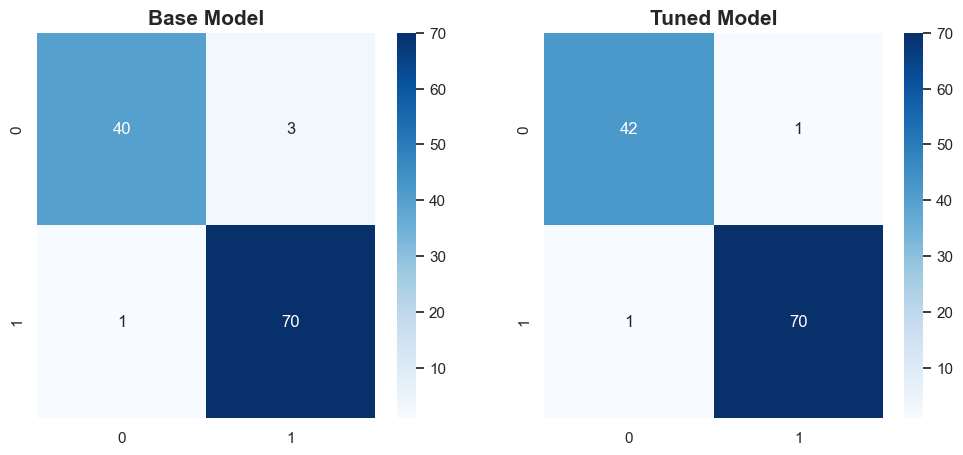

In [80]:
# use best estimator model and compare with base models
logreg = pickle.load(open(f'{MODEL_DIR}logreg.pkl', 'rb'))
tuned_logreg = grid.best_estimator_

tuned_logreg.fit(X_train, y_train)

y_pred_tuned = tuned_logreg.predict(X_test)
y_pred_base = logreg.predict(X_test)

print("Base Accuracy: ", accuracy_score(y_test, pred_models['logreg']))
print("Tuned Accuracy: ", accuracy_score(y_test, y_pred_tuned))

# get confusioon matrix of tuned model and visualize
fig, (ax_base, ax_tuned) = plt.subplots(1,2 , figsize=(12,5))
conf_mat_tuned = confusion_matrix(y_true=y_test, y_pred=y_pred_tuned)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_base)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, ax=ax_base)
ax_base.set_title('Base Model', fontsize=15, fontweight='bold')

sns.heatmap(conf_mat_tuned, annot=True, fmt='d', cmap=plt.cm.Blues, ax=ax_tuned)
ax_tuned.set_title('Tuned Model', fontsize=15, fontweight='bold')
plt.show()


_On the top of the cake, the model improved!_

Apabila dibandingkan dengan **base model**, performa model yang telah dituning mengalami peningkatan pada keseluruhan _metrics_. Hyperparamter tuning sendiri biasanya merupakan teknik yang dilakukan di akhir saat pemilihan model telah terdefinisi dengan jelas, kemampuan hyperparamater tuning sendiri umumnya tidak dapat meningkatkan performa secara drastis, tetapi layak dicoba apabila ingin mencoba mendapatkan performa yang lebih baik dengan waktu komputasi yang _reasonable_.

------

13520085 & 13520109 - IF3270, 2023